In [16]:
import sys
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt

plt.style.use('ggplot')

matplotlib.rcParams.update({'figure.figsize': (10, 6)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})

%config InlineBackend.figure_format = 'retina'

# Machine Learning Lab 5: Evaluation and Multi-Layer Perceptron

In [2]:
m = pd.read_csv('movie_metadata.csv')

# Reorder the DataFrame to a more intelligent fashion
m = m[[
    'movie_title','title_year',
    'genres', 'plot_keywords', 'duration',
    'budget', 'gross',
    'language', 'country', 'content_rating',
    'color', 'aspect_ratio',
    'facenumber_in_poster',
    'director_name',
    'actor_1_name', 'actor_2_name', 'actor_3_name',
    'movie_facebook_likes', 'director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
    'actor_3_facebook_likes', 'cast_total_facebook_likes',
    'movie_imdb_link', 'num_user_for_reviews', 'num_critic_for_reviews', 'num_voted_users',
    'imdb_score',
]]

In [3]:
# Reduce the number of float64 data types for columns that do not need a float64 data type
for col in ['title_year','facenumber_in_poster',
'movie_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes',
'actor_3_facebook_likes','cast_total_facebook_likes','num_user_for_reviews',
'num_critic_for_reviews','num_voted_users']:
    m[col] = pd.to_numeric(m[col],downcast='integer')
  
# Remove all duplicate entries
m.drop_duplicates(inplace=True)

# Create a copy to perserve the original DataFrame
m_original=m.copy()
m.head()

,movie_title,title_year,genres,plot_keywords,duration,budget,gross,language,country,content_rating,...,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,cast_total_facebook_likes,movie_imdb_link,num_user_for_reviews,num_critic_for_reviews,num_voted_users,imdb_score
0,Avatar,2009.0,Action|Adventure|Fantasy|Sci-Fi,avatar|future|marine|native|paraplegic,178.0,237000000.0,760505847.0,English,USA,PG-13,...,0.0,1000.0,936.0,855.0,4834,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,723.0,886204,7.9
1,Pirates of the Caribbean: At World's End,2007.0,Action|Adventure|Fantasy,goddess|marriage ceremony|marriage proposal|pi...,169.0,300000000.0,309404152.0,English,USA,PG-13,...,563.0,40000.0,5000.0,1000.0,48350,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,302.0,471220,7.1
2,Spectre,2015.0,Action|Adventure|Thriller,bomb|espionage|sequel|spy|terrorist,148.0,245000000.0,200074175.0,English,UK,PG-13,...,0.0,11000.0,393.0,161.0,11700,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,602.0,275868,6.8
3,The Dark Knight Rises,2012.0,Action|Thriller,deception|imprisonment|lawlessness|police offi...,164.0,250000000.0,448130642.0,English,USA,PG-13,...,22000.0,27000.0,23000.0,23000.0,106759,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,813.0,1144337,8.5
4,Star Wars: Episode VII - The Force Awakens ...,NaN,Documentary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,131.0,131.0,12.0,NaN,143,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,8,7.1


In [4]:
# Remove all films except those from the United States
m = m[m['country'] == 'USA']

In [5]:
# Remove items with non-American or non-film rating systems
m = m[m['content_rating'].isin(['R','PG-13','PG','G'])]

In [6]:
# Remove rows where the value is null
for col in ['title_year', 'language','country','content_rating',
'aspect_ratio','duration', 'color','gross','budget','movie_facebook_likes',
'actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes',
'cast_total_facebook_likes']:
    try:
        m = m[pd.notnull(m[col])]
    except KeyError:
        pass
    
# Assume null review counts are 0
for col in ['num_user_for_reviews','num_critic_for_reviews']:
    m[col].fillna(value=0,inplace=True)
    
# Assume missing face counts are the mean
avgFace = round(m['facenumber_in_poster'].mean())
m['facenumber_in_poster'].fillna(value=avgFace, inplace=True)

In [7]:
# Categorize the IMDB score into three classes:
# [0%-49%] is Poor, [50%-89%] is Average, [90%-100%] is Good.
poor_avg = m['imdb_score'].quantile(.5)
avg_good = m['imdb_score'].quantile(.9)

m['rating_category'] = pd.cut(
    m.imdb_score,[0,poor_avg,avg_good,10],
    labels=['poor','average','good']
)

In [8]:
for c in ['movie_title','plot_keywords','actor_1_name','actor_2_name','actor_3_name',
'movie_imdb_link','genres', 'director_name','imdb_score','aspect_ratio','country','language']:
    m.drop(c, axis=1, inplace=True)

In [9]:
# Convert categorical values to category type
for col in ['content_rating','color']:
    m[col] = m[col].astype('category')

In [10]:
# replace color and content_rating with dummies
m = pd.get_dummies(m, columns=['color','content_rating'])

In [11]:
if m.rating_category.dtype != np.dtype('int8'):
    m.rating_category = m.rating_category.cat.codes
m.rating_category.value_counts()

0    1560
1    1086
2     276
Name: rating_category, dtype: int64

In [12]:
m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 5042
Data columns (total 21 columns):
title_year                   2922 non-null float64
duration                     2922 non-null float64
budget                       2922 non-null float64
gross                        2922 non-null float64
facenumber_in_poster         2922 non-null float64
movie_facebook_likes         2922 non-null int32
director_facebook_likes      2922 non-null float64
actor_1_facebook_likes       2922 non-null float64
actor_2_facebook_likes       2922 non-null float64
actor_3_facebook_likes       2922 non-null float64
cast_total_facebook_likes    2922 non-null int32
num_user_for_reviews         2922 non-null float64
num_critic_for_reviews       2922 non-null float64
num_voted_users              2922 non-null int32
rating_category              2922 non-null int8
color_ Black and White       2922 non-null uint8
color_Color                  2922 non-null uint8
content_rating_G             2922 non-n

# Filler

In [13]:
class MultiLayerPerceptron(object):
	def __init__(
		self, alpha=0.0, decrease_const=0.0, shuffle=True, minibatches=1, # n_hidden=30
		hidden_layer_sizes=[10,10,10], C=0.0, epochs=500, eta=0.001, random_state=None,
		activation_function='sigmoid', cost_function='least_squares'
	):
		# need to add to the original initializer 
		self.alpha = alpha
		self.decrease_const = decrease_const
		self.shuffle = shuffle
		self.minibatches = minibatches

		np.random.seed(random_state)
		#self.n_hidden = n_hidden
		self.hidden_layer_sizes = hidden_layer_sizes
		self.l2_C = C
		self.epochs = epochs
		self.eta = eta
		self.activation_function = activation_function
		self.cost_function = cost_function

		if DEBUG:
			# an `n layer perceptron` has n-1 hidden layers
			print(f'MultiLayerPerceptron ({len(hidden_layer_sizes)+1}-layer perceptron)')
			print(f'\tactivation function: {activation_function}')
			print(f'\tcost function: {cost_function}')
			print(f'\thidden layers: {len(hidden_layer_sizes)}, sizes: {hidden_layer_sizes}')
			print(f'\talpha = {alpha}, decrease_const = {decrease_const}, shuffling: {"yes" if shuffle else "no"}')
			print(f'\tmini batches = {minibatches}, C = {C}, epochs = {epochs}, eta = {eta}')
		
	@staticmethod
	def _encode_labels(y):
		"""Encode labels into one-hot representation"""
		onehot = pd.get_dummies(y).values.T
		return onehot

	def _initialize_weights(self):
		"""Initialize weights with small random numbers."""

		#W1_num_elems = (self.n_features_ + 1)*self.n_hidden
		#W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
		#W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
		
		#W2_num_elems = (self.n_hidden + 1)*self.n_output_
		#W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
		#W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
		#return W1, W2

		weights = []

		sizes = [self.n_features_, *self.hidden_layer_sizes, self.n_output_]
		pairs = zip(sizes[0::1], sizes[1::1])

		for previous_size, next_size in pairs:
			weight_size = (previous_size + 1) * next_size
			weight = np.random.uniform(-1.0, 1.0, size=weight_size)
			weight = weight.reshape(next_size, previous_size + 1)
			weights.append(weight)

		"""if DEBUG:
			print('\n_initialize_weights')
			[print(f'weights[{i}].shape = {x}') for i,x in list(enumerate(map(lambda X:X.shape, weights)))]
		"""
		
		return weights
	
	def _activation_function(self, z):
		new_z = np.copy(z)
		if self.activation_function == 'linear':
			# normalize within -1.0...1.0
			new_z /= np.max(np.abs(new_z),axis=0)
			return new_z
		elif self.activation_function == 'sigmoid':
			return expit(new_z)
		else:
			raise ValueError(
				'The activation_function parameter was an unexpected value:',
				f'"{self.activation_function}" (should be "linear" or "sigmoid")'
			)

	#@staticmethod
	#def _sigmoid(z):
	#	"""Use scipy.special.expit to avoid overflow"""
	#	# 1.0 / (1.0 + np.exp(-z))
	#	return expit(z)
	
	@staticmethod
	def _add_bias_unit(X, how='column'):
		"""Add bias unit (column or row of 1s) to array at index 0"""
		if how == 'column':
			ones = np.ones((X.shape[0], 1))
			X_new = np.hstack((ones, X))
		elif how == 'row':
			ones = np.ones((1, X.shape[1]))
			X_new = np.vstack((ones, X))
		return X_new
	
	@staticmethod
	def _without_bias(X, how='column'):
		if how == 'column':
			return X[:,1:]
		elif how == 'row':
			return X[1:,:]
	
	@staticmethod
	#def _L2_reg(lambda_, W1, W2)
	def _L2_reg(lambda_, weights):
		"""Compute L2-regularization cost"""
		# only compute for non-bias terms
		# TODO: vectorize
		result = 0.0
		for weight in weights:
			result += np.mean(weight[:, 1:] ** 2)
		return (lambda_/2.0) * np.sqrt(result)
		#return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
	
	#def _cost(self,A3,Y_enc,W1,W2):
	def _cost(self,An,Y_enc,weights):
		'''Get the objective function value'''
		# COST FUNCTION
		cost = 0.0
		if self.cost_function == 'least_squares':
			cost = np.mean((Y_enc-An)**2)
		elif self.cost_function == 'cross_entropy':
			cost = np.mean(Y_enc * np.log(An) + (1.0 - Y_enc) * np.log(1.0 - An))
		else:
			raise ValueError(f'Expected cost function names "least_squares" or "cross_entropy" ("{self.cost_function}")')
		
		# REGULARIZATION
		#L2_term = self._L2_reg(self.l2_C, W1, W2)
		L2_term = self._L2_reg(self.l2_C, weights)
		result = cost+L2_term
		if np.any(np.isnan(result)):
			raise ValueError('NaN value passed into cost function.')
		return result
	
	#def _feedforward(self, X, W1, W2):
	def _feedforward(self, X, weights):
		"""Compute feedforward step
		-----------
		X : Input layer with original features.
		weights (size n)
		weights[0]: Weight matrix for input layer -> hidden layer.
		weights[1...n-2]: Weight matrices for hidden layer -> hidden layer.
		weights[n-1]: Weight matrix for hidden layer -> output layer.
		----------
		a (size n+1): activations into layer (or output layer)
		z (size n): layer inputs 

		"""
		A = []
		Z = []

		#A1 = self._add_bias_unit(X, how='column')
		#Z1 = W1 @ A1.T
		#A2 = self._sigmoid(Z1)
		#A2 = self._add_bias_unit(A2, how='row')
		#Z2 = W2 @ A2
		#A3 = self._sigmoid(Z2)
		#return A1, Z1, A2, Z2, A3

		# input case
		# A1
		A.append(self._add_bias_unit(X, how='column'))
		# Z1
		Z.append(weights[0] @ A[0].T)

		for i in range(1, len(self.hidden_layer_sizes)+1):
			a = self._activation_function(Z[-1])
			a = self._add_bias_unit(a, how='row')
			A.append(a)

			# Z2 = W2 @ A2 and so on (but zero-indexed)
			z = weights[i] @ A[i]
			Z.append(z)

		# output case
		an = self._activation_function(Z[-1])
		A.append(an)
		"""
		if DEBUG:
			print('\n_feedforward')
			[print(f'A[{i}].shape = {x}') for i,x in list(enumerate(map(lambda X:X.shape, A)))]
			print()
			[print(f'Z[{i}].shape = {x}') for i,x in list(enumerate(map(lambda X:X.shape, Z)))]
		"""
		return A,Z
	
#	def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
	def _get_gradient(self, A, Z, Y_enc, weights):
		""" Compute gradient step using backpropagation.
		"""
		# vectorized backpropagation
		#sigma2 = -2*(Y_enc-A3)*A3*(1-A3)
		#grad2 = sigma2 @ A2.T

		#sigma1 = (W2.T @ sigma2)*A2*(1-A2)
		#grad1 = sigma1[1:,:] @ A1

		# the derivative varies if we're using sigmoid or linear activation
		derivative = lambda a: 0
		if self.activation_function == 'linear':
			derivative = lambda a: 1
		elif self.activation_function == 'sigmoid':
			derivative = lambda a: a*(1-a)

		sigmas = [None] * len(Z)
		gradients = [None] * len(Z)

		# output layer case
		s = len(sigmas)-1
		
		"""
		if DEBUG:
			print(f'\n_get_gradient output layer case [{s}]')
		"""
		
		# sigmas[s] = -2.0*(Y_enc-A[s+1])*A[s+1]*(1-A[s+1])
		sigmas[s] = -2.0*(Y_enc-A[s+1])*derivative(A[s+1])
		gradients[s] = sigmas[s] @ A[s].T
		
		"""
		if DEBUG:
			print(f'\tsigmas[{s}].shape = {sigmas[s].shape}')
		"""
		
		one_hidden_layer = s == 1

		# first hidden layer case
		if not one_hidden_layer:
			# sigmas[s-1] = (weights[s].T @ sigmas[s])*A[s]*(1-A[s])
			sigmas[s-1] = (weights[s].T @ sigmas[s])*derivative(A[s])
			gradients[s-1] = self._without_bias(sigmas[s-1],how='row') @ A[s-1].T

		# remaining hidden layer case
		for i in reversed(range(1, len(Z)-2)):
			"""
			if DEBUG:
				print(f'\n_get_gradient hidden layer case [{i}]')
			"""
			try:
				# sigmas[i] = (weights[i+1].T @ self._without_bias(sigmas[i+1],how='row'))*A[i+1]*(1-A[i+1])
				sigmas[i] = (weights[i+1].T @ self._without_bias(sigmas[i+1],how='row'))*derivative(A[i+1])
				gradients[i] = self._without_bias(sigmas[i],how='row') @ A[i].T
				"""
				if DEBUG:
					print(f'\tsigmas[{i}].shape = {sigmas[i].shape}')
				"""
			except ValueError:
				if DEBUG:
					print('\n_get_gradient')
					print(f'ERROR:\nweights[{i+1}].shape (i+1) = {weights[i+1].shape}')
					print(f'A[{i}].shape (i) = {A[i].shape}')
					print(f'A[{i+1}].shape (i+1) = {A[i+1].shape}')
					print(f'sigmas[{i+1}].shape (i+1) = {sigmas[i+1].shape}\n\n')
				raise

		# input layer case
		next_sigma = sigmas[1]
		if not one_hidden_layer:
			next_sigma = self._without_bias(next_sigma,how='row')
		
		# sigmas[0] = (weights[1].T @ next_sigma)*A[1]*(1-A[1])
		sigmas[0] = (weights[1].T @ next_sigma)*derivative(A[1])
		gradients[0] = self._without_bias(sigmas[0],how='row') @ A[0]

		# regularize weights that are not bias terms
		#grad1[:, 1:] += W1[:, 1:] * self.l2_C
		#grad2[:, 1:] += W2[:, 1:] * self.l2_C

		for i in range(len(gradients)):
			try:
				gradients[i][:, 1:] += self._without_bias(weights[i], how='column') * self.l2_C
			except ValueError:
				if DEBUG:
					print('\n\n')
					print('\n\n','='*50,'\n_get_gradient',sep='')
					print(f'\nERROR: gradients[{i}].shape = {gradients[i].shape}')
					print(f'weights[i].shape = {weights[i].shape}')
					print('\n')
				raise

		#return grad1, grad2
		return gradients
	
	def predict(self, X):
		"""Predict class labels"""
		#_, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
		#y_pred = np.argmax(A3, axis=0)

		A, _ = self._feedforward(X, self.weights)
		y_pred = np.argmax(A[-1], axis=0)
		return y_pred
	
	def fit(self, X, y, print_progress=False):
		""" Learn weights from training data."""
		
		X_data, y_data = X.copy(), y.copy()
		Y_enc = self._encode_labels(y)
		
		# init weights and setup matrices
		self.n_features_ = X_data.shape[1]
		self.n_output_ = Y_enc.shape[0]
		# self.W1, self.W2 = self._initialize_weights()
		self.weights = self._initialize_weights()

		self.cost_ = []
		for i in range(self.epochs):

			if print_progress > 0 and (i+1) % print_progress == 0:
				sys.stderr.write(f'\rEpoch: {i+1}/{self.epochs}')
				sys.stderr.flush()

			# feedforward all instances
			#A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2)
			A, Z = self._feedforward(X_data, self.weights)
			
			# cost = self._cost(A3,Y_enc,self.W1,self.W2)
			cost = self._cost(A[-1], Y_enc, self.weights)
			self.cost_.append(cost)

			# compute gradient via backpropagation
			#grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
			#								  W1=self.W1, W2=self.W2)
			gradients = self._get_gradient(A, Z, Y_enc, self.weights)
			# self.W1 -= self.eta * grad1
			# self.W2 -= self.eta * grad2
			for i, gradient in enumerate(gradients):
				self.weights[i] -= self.eta * gradient
		if print_progress > 0:
			print()
		return self

In [32]:
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.special import expit
from sklearn.model_selection import train_test_split

DEBUG = False

X=m.drop('rating_category', axis=1, inplace=False)
y=np.ravel(m['rating_category'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

"""if DEBUG:
    print('X train:',X_train.shape)
    print('y train:',y_train.shape)
    print('X test:',X_test.shape)
    print('y test:',y_test.shape)
"""
nn = MultiLayerPerceptron(
    hidden_layer_sizes=[50,50,50], 
    C=0.01, # tradeoff L2 regularizer
    epochs=400, # iterations
    eta=0.001,  # learning rate
    random_state=1,
    alpha=0.001,# momentum calculation
    decrease_const=0.0001, # decreasing eta
    minibatches=50, # minibatch size
    shuffle=True,
    activation_function='sigmoid',
    cost_function='cross_entropy'
)

nn.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)

print('accuracy:',accuracy_score(y_test,yhat))

Epoch: 400/400


accuracy: 0.560683760684


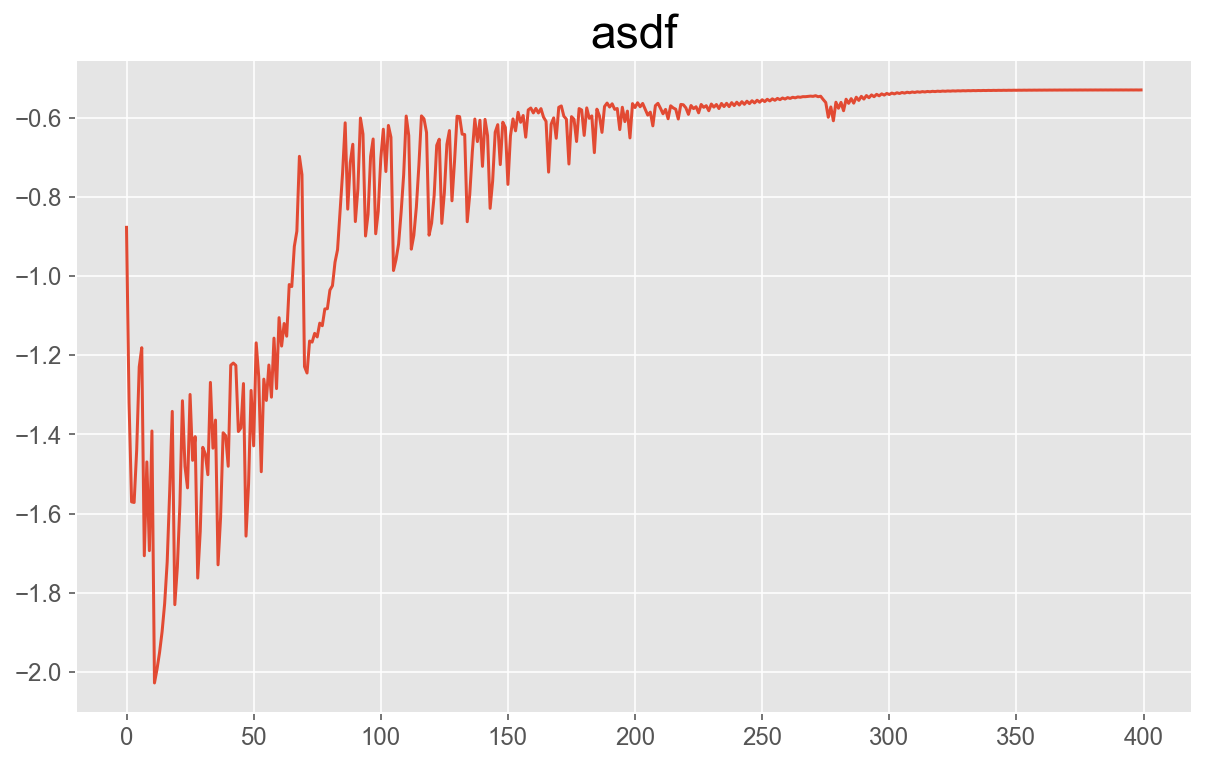

In [33]:
fig, ax = plt.subplots()
plt.plot(np.arange(nn.epochs), nn.cost_)
plt.title('asdf')
# plt.ylim(-2.0,0)
plt.show()

In [39]:
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
etas = [0.000001, 0.00001, 0.0001, 0.001, 0.01]

C_grid, eta_grid = np.meshgrid(C_grid, eta_grid)

@np.vectorize
def test_nn(C,eta):
    nn = MultiLayerPerceptron(
        hidden_layer_sizes=[10,10,10], 
        C=C, # tradeoff L2 regularizer
        epochs=350, # iterations
        eta=eta,  # learning rate
        random_state=1,
        alpha=0.001,# momentum calculation
        decrease_const=0.0001, # decreasing eta
        minibatches=50, # minibatch size
        shuffle=True,
        activation_function='sigmoid',
        cost_function='cross_entropy'
    )
    nn.fit(X_train, y_train, print_progress=0)
    yhat = nn.predict(X_test)
    return accuracy_score(y_test,yhat)

scores = test_nn(C_grid, eta_grid)

In [43]:
print(scores.max())

0.567521367521
